<a href="https://colab.research.google.com/github/JunnieLee/ML_finance/blob/master/stock_prediction_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [ver_1]. 딥러닝 모델 - RNN - LSTM

> Keras 기반의 딥러닝 모델 중 LSTM (Long Short Term Memory) 사용

* RNN (Recurrent Neural Network) 구조 : 출력이 다시 state의 입력으로 들어옴

표현: ht=fw(ht-1, xt)

(ht-1 : old state)
(xt : input vector)
(fw: function with parameters W)
(ht : new state)

- RNN은 학습을 할 때 현재 입력값뿐만 아니라 이전에 들어온 입력값을 함께 고려하기 때문에 시계열 데이터를 학습하기에 적합

> RNN 모델 중에서도 LSTM 사용

- RNN은 데이터가 너무 길어지면 이를 표현하는 신경망이 깊어져야만 함. RNN은 역전파(Backpropagation)라는 방법을 통해 학습하는데, 위와 같은 경우 그래디언트가 너무 작아져 학습이 잘 안 되는 문제(Vanishing Gradient Problem)가 발생. 이 문제를 해결하기 위해 LSTM을 사용.


- LSTM은 셀 스테이트(cell state)라는 개념을 도입하여 그 내부에 있는 게이트(gate)들을 통해 어떤 정보를 기억하고 어떤 정보를 버릴지 추가적인 학습을 가능하게 함. 이를 통해 RNN이 가진 문제(Vanishing Gradient Problem)를 해결할 수 있음.

## 0. import modules

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
import datetime

## 1. Naver 5년치 주식 데이터 load하기

- yahoo finance 이용
- https://finance.yahoo.com/quote/035420.KS?p=035420.KS&.tsrc=fin-srch

In [0]:
data = pd.read_csv(r"C:\Users\junnie\Desktop\035420.KS.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-14,133600.0,137200.0,132400.0,133400.0,129508.875000,981955
1,2014-01-15,134800.0,139000.0,133400.0,138600.0,134557.187500,787795
2,2014-01-16,140800.0,144200.0,140200.0,144000.0,139799.671875,809200
3,2014-01-17,144000.0,144200.0,141600.0,143000.0,138828.859375,469025
4,2014-01-20,143000.0,145600.0,142800.0,143400.0,139217.171875,367725


## 2. High-Low 평균값 계산

In [0]:
high = data['High'].values
low = data['Low'].values
mid = (high + low) / 2

## 3. Window 생성

In [0]:
input_size = 50 # 최근 50일 데이터를 가지고 그 다음날 1일의 데이터를 예측
window_size = input_size + 1

windows = [] # 2D list가 될것임
for i in range(len(mid) - window_size): 
    windows.append(mid[i: i + window_size]) # loop이 돌때마다 한칸씩 밀리며 51개씩의 window package 생성

## 4. 데이터 정규화

In [0]:
normalized = []
for window in windows:
    normalized_window = [((float(i) / float(window[0])) - 1) for i in window]
    # window[0] 자리에 있는 애의 mid 가격 값이 0이되도록 설정해줌.
    normalized.append(normalized_window)
    
# 정규화된 window값들을 numpy array로 변환
result = np.array(normalized)
# 각 window가 하나씩의 row를 이루겠지

## 5. train data/ test data 나누기

In [0]:
row = int(round(result.shape[0] * 0.9)) # 약 90%를 training set으로
train = result[:row, :]
np.random.shuffle(train)


x_train = train[:, :-1] # 50개 data씩 학습시킬꺼니까 x_train 한 행에 50열씩
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) # 3D array로 변환
y_train = train[:, -1] # 50일 그 다음날 하루 예측해야하니까 y_train에 한 행에 1열씩


x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) # 뭉탱이 / 뭉탱이 행 / 뭉탱이 열
y_test = result[row:, -1]

x_train.shape, x_test.shape

((1057, 50, 1), (117, 50, 1))

## 6. 모델 생성

In [0]:
# keras.models.Sequential() --> 모델을 순차적으로 정의하는 Sequential 클래스 사용
model = Sequential()

# [input]
# keras.layers.LSTM
# model.add로 LSTM 레이어 추가
model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))
model.add(LSTM(64, return_sequences=False))

# [output]
# keras.layers.Dense --> fully connected layer
model.add(Dense(1, activation='linear'))

# loss function --> Mean Squared Error
model.compile(loss='mse', optimizer='rmsprop')

# 모델 개요 출력
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


## 7. 생성한 모델로 학습시키기

In [0]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10, # 한번에 10개씩 묶어서 학습
    epochs=20)# 20번동안 반복학습

Train on 1057 samples, validate on 117 samples
Epoch 1/20
1057/1057 [==============================] - 83s 79ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 2/20
1057/1057 [==============================] - 49s 46ms/step - loss: 7.7318e-04 - val_loss: 9.4774e-04
Epoch 3/20
1057/1057 [==============================] - 52s 49ms/step - loss: 5.5604e-04 - val_loss: 7.2773e-04
Epoch 4/20
1057/1057 [==============================] - 55s 52ms/step - loss: 4.5347e-04 - val_loss: 5.4069e-04
Epoch 5/20
1057/1057 [==============================] - 56s 53ms/step - loss: 3.7463e-04 - val_loss: 3.8304e-04
Epoch 6/20
1057/1057 [==============================] - 56s 53ms/step - loss: 3.3627e-04 - val_loss: 3.5513e-04
Epoch 7/20
1057/1057 [==============================] - 58s 55ms/step - loss: 3.0250e-04 - val_loss: 4.7358e-04
Epoch 8/20
1057/1057 [==============================] - 48s 45ms/step - loss: 2.9470e-04 - val_loss: 3.9702e-04
Epoch 9/20
1057/1057 [==============================] - 40s 38ms/

## 8. 예측

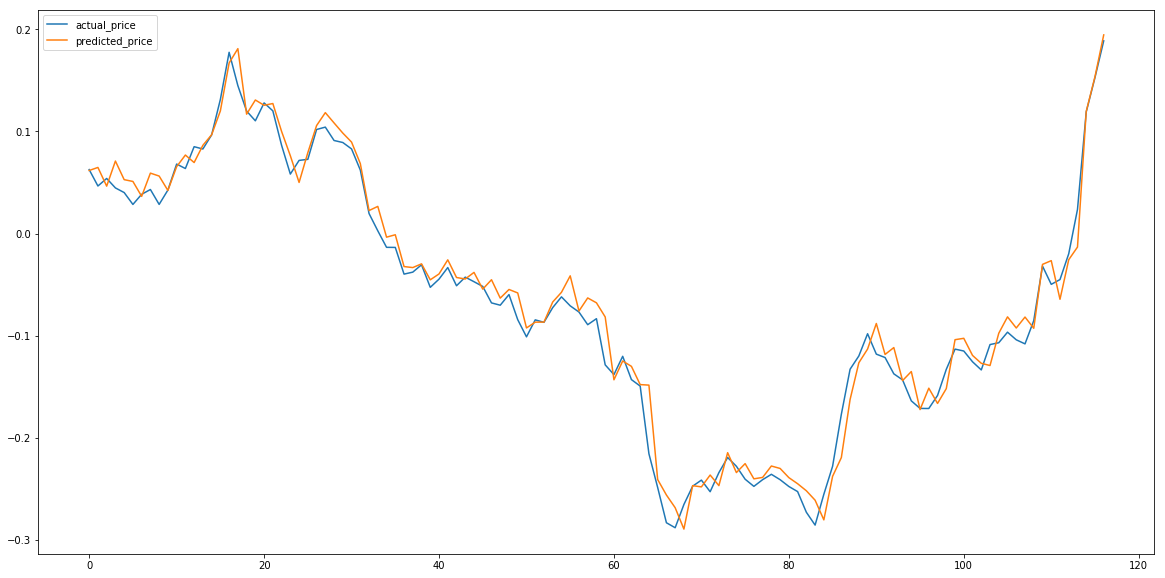

In [0]:
pred = model.predict(x_test) # 테스트 데이터 예측

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='actual_price')
ax.plot(pred, label='predicted_price')
ax.legend()
plt.show()